
# Google Landmark Recognition Challenge

### by-
   ### Sufiyan Adhikari (173190009)
   ### Jaswant Singh    (173190020)
   ### Khyati Thakkar   (173194001)


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
train = pd.read_csv("data/train.csv")
train.head()

,id,url,landmark_id
0,cacf8152e2d2ae60,http://static.panoramio.com/photos/original/70...,4676
1,0a58358a2afd3e4e,http://lh6.ggpht.com/-igpT6wu0mIA/ROV8HnUuABI/...,6651
2,6b2bb500b6a38aa0,http://lh6.ggpht.com/-vKr5G5MEusk/SR6r6SJi6mI/...,11284
3,b399f09dee9c3c67,https://lh3.googleusercontent.com/-LOW2cjAqubA...,8429
4,19ace29d77a5be66,https://lh5.googleusercontent.com/-tnmSXwQcWL8...,6231


# Data Handling

### Data Sampling

As Data size is Huge and Data is [Highly Skewed](https://www.kaggle.com/codename007/a-very-extensive-landmark-exploratory-analysis),  
Sampling was required to make sure everything works before training on whole data.

train: 336 GB with 1,220,165 images 
test: 34.9 GB with 116,163 images

Data was downloaded [with]() this script, reducing the resolution to *299* from *1600*
as demonstrated 

In [2]:
def show_count(train):
    temp = pd.DataFrame(train.landmark_id.value_counts())
    temp.reset_index(inplace=True)
    temp.columns = ['landmark_id','count1']
    temp = pd.DataFrame(temp.count1.value_counts())
    temp = temp.sort_index()
    temp.reset_index(inplace=True)
    temp.columns = ["Photos","Id Count"]
    print("Landmark IDs with Very Few Photos: \n")
    print(temp.head())
    print("\n\nLandmarks IDs with Very High Number of Photos \n")
    print(temp.tail())
show_count(train)

Landmark IDs with Very Few Photos: 

   Photos  Id Count
0       1       159
1       2       291
2       3       631
3       4       999
4       5      1314


Landmarks IDs with Very High Number of Photos 

     Photos  Id Count
759   13271         1
760   18471         1
761   23415         1
762   50148         1
763   50337         1


In [2]:
!ls data

models			   test		 test_n.csv  train.csv	    valid
sample_submission.csv	   test.csv	 tmp	     train.csv.zip
sample_submission.csv.zip  test.csv.zip  train	     train_n.csv


In [2]:
import os
HOME = os.getenv("HOME")
os.chdir(HOME)

### Reducing Train Data and Extracting Validation Data
As we can see above, 159 Landmark IDs have only 1 photo, 259 have only 2 photos, etc.
where as, a few IDs have photos in excess of several thousand.
The Below function was written to take in the original train.csv file and reduce it to include maximum *trn_sz* photos of each landmark for training, and also generate maximum *val_sz* of validation photo indexes of each landmark if it has more than *trn*sz* photos and save it in a python list as required by **fastai** library

It Dumps these into a pickle file with name train_val_<trn_sz>_<val_sz>.pkl

and can be imported as *train, val_idxs = joblib.load(filename)*

In [ ]:
#Was written to check the photos in train dataset, not downloaded.

missing_in_train = []
for i, row in train.iterrows():
    filename = f'{HOME}/data/train/{row["id"]}.jpg'
    if not os.path.exists(filename): 
        missing_in_train.append(i)
    elif 0 == os.path.getsize(filename):
        #Deleting the empty files
        os.unlink(filename)
        missing_in_train.append(i)
print("Number of Photos Not Downloaded: ", len(missing_in_train))

os.chdir(HOME)
train.drop(index=missing_in_train, inplace=True)
train.to_csv("data/train.csv", index=False)

In [5]:
os.chdir("data")
train_data = pd.read_csv('train.csv')
print("Actual Training Data Size: ",train_data.shape)
temp=pd.DataFrame(train_data.landmark_id.value_counts())
temp.reset_index(inplace=True)
temp.columns = ['landmark_id','count']
os.chdir(HOME)

Actual Training Data Size:  (1225029, 3)


In [6]:
train_data = pd.read_csv('data/train.csv')
print("Actual Training Data Size: ",train_data.shape)
temp=pd.DataFrame(train_data.landmark_id.value_counts())
temp.reset_index(inplace=True)
temp.columns = ['landmark_id','count']
temp.head()

Actual Training Data Size:  (1225029, 3)


,landmark_id,count
0,9633,50337
1,6051,50148
2,6599,23415
3,9779,18471
4,2061,13271


## Training Starts Here

In [13]:
#Fastai Labrary is used and all codes for the library are used from 
#fast.ai's Deep Learning course 1 v2 2018


#To add fastai to system path
import sys
sys.path.append(f'{HOME}/fastai')



# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

PATH = f'{HOME}/data/'
sz=64
arch = resnext50
bs=64


In [9]:
torch.cuda.is_available()

True

In [6]:
os.chdir(f'{PATH}train')

In [11]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=8)
learn = ConvLearner.pretrained(arch, data, precompute=True, xtra_fc=[5000])
    

100%|██████████| 155/155 [00:19<00:00,  7.78it/s]


 80%|███████▉  | 14828/18563 [10:29<02:38, 23.56it/s, loss=23.1]

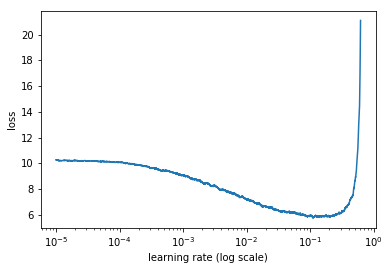

In [12]:
lrf=learn.lr_find()
learn.sched.plot()

We Select an optimal Learning Rate of 0.05 from the above plot

In [13]:
lr = 0.05

In [14]:
learn.fit(lr, 1)

  2%|▏         | 434/18563 [00:07<05:27, 55.33it/s, loss=8.35]
epoch      trn_loss   val_loss   accuracy                       
    0      4.990365   11.734937  0.000101  



[array([11.73494]), 0.00010082677959265981]

In [15]:
learn.save(f'model_{sz}_1')

In [16]:
learn.precompute=False
learn.fit(lr, 2, cycle_len=1)
learn.save(f'model_{sz}_2')

epoch      trn_loss   val_loss   accuracy                       
    0      4.84581    12.167926  0.000101  
    1      4.616157   12.441432  0.000101                       



### OverFitting Model
We can see from above that the model is overfitting.
This is probably due to some landmarks have a lot more photos that the others.
Skewed Dataset needs to be handelled.
Trying Solution:
Limiting max photos of each landmark to 30
Creating copies of photos if photos of a landmark are below 30.

In [34]:
import os
import random
import multiprocessing
import tqdm
from shutil import copyfile, move

empty_dir = []
def sort_dir(some_dir):
    if os.path.isdir(f'{PATH}/train/{some_dir}'):
        files = os.listdir(f'{PATH}/train/{some_dir}')
        if len(files)>30:
            if len(files)<60:
                for file in files[30:]:
                    os.renames(f'{TRAIN}/{some_dir}/{file}', f'{EXTRA}/{some_dir}/{file}')
    #                 !mv f'{TRAIN}/{some_dir}/{file}' f'{EXTRA}/{some_dir}/{file}'
            else:
                move(f'{TRAIN}/{some_dir}', f'{EXTRA}')
                for file in files[30:]:
                    os.renames(f'{EXTRA}/{some_dir}/{file}', f'{TRAIN}/{some_dir}/{file}')
        elif len(files)<30 and len(files)>=1:
            count=len(files)
            while count <30:
                for file in files:
                    if count<30:  
                        copyfile(f'{TRAIN}/{some_dir}/{file}', 
                            f"{TRAIN}/{some_dir}/{'%020x' % random.randrange(16**20)}.jpg")
    #                     !ln f'{TRAIN}/{some_dir}/{file}' f"{TRAIN}/{some_dir}/{'%020x' % random.randrange(16**20)}.jpg"
                        count+=1
        elif len(files)==0:
            empty_dir.append(some_dir)
    return 1              
                    
                    
HOME=os.getenv("HOME")
PATH = f'{HOME}/data'
TRAIN = f'{PATH}/train'
EXTRA = f'{PATH}/extra'
dir_list = os.listdir(f'{PATH}/train')
pool = multiprocessing.Pool(processes=8) #no. of parallel processes
total = sum(tqdm.tqdm(pool.imap_unordered(sort_dir , dir_list), total=len(dir_list)))
print(f"Total Directories Sorted: {total}")                    
print("Done Setting Data!")
print(f"Total Empty Directory: {len(empty_dir)}")


100%|██████████| 14951/14951 [00:01<00:00, 7804.04it/s]

Total Directories Sorted: 14951
Done Setting Data!
Total Empty Directory: 0


### Now We Define the Model Again
Here, We define the model again and train it on the modified dataset.
As we said above, we are making all the landmark_id s to have around 30 images each to avoid overfitting problem faced above.

In [35]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=8)
learn = ConvLearner.pretrained(arch, data, precompute=True, xtra_fc=[5000])

 87%|████████▋ | 5175/5929 [02:20<00:20, 36.77it/s, loss=31.6]

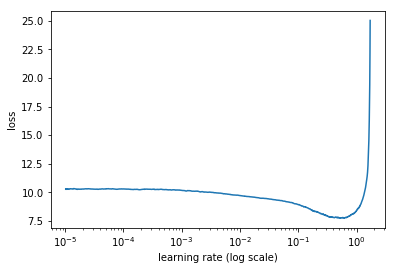

 87%|████████▋ | 5175/5929 [02:40<00:23, 32.33it/s, loss=31.6]

In [16]:
lrf=learn.lr_find()
learn.sched.plot()

In [36]:
lr = 0.001

In [ ]:
learn.fit(lr, n_cycle=1, cycle_len=6)


100%|█████████▉| 5927/5929 [02:39<00:00, 37.14it/s, loss=9.67]

# Still Overfitting 
The model is overfitting even after making number of photos of each label 30.


# Reducing Labels
After contacting Amit Sethi Sir, I am reducing the number of labels to only 240, taking landmarks that have more than 700 photos each.
680 photos are used in Train Set, 20 each in Validation set and upto 100 (above 600 util 700) are used in Test set.

In [3]:
#Data changed as above.
#Fastai Labrary is used and all codes for the library are used from 
#fast.ai's Deep Learning course 1 v2 2018

#To add fastai to system path
import sys
import os
HOME = os.getenv("HOME")
sys.path.append(f'{HOME}/fastai')



# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

PATH = f'{HOME}/data/'
sz=299
arch = resnext50
bs=64

In [5]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=8)
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 75/75 [01:35<00:00,  1.27s/it]


 81%|████████  | 1758/2166 [00:33<00:07, 53.23it/s, loss=7.79]

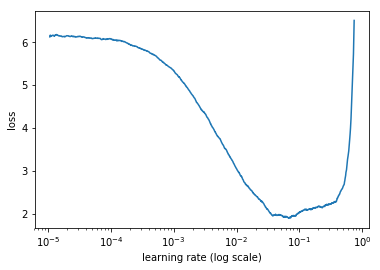

 81%|████████  | 1758/2166 [00:50<00:11, 35.16it/s, loss=7.79]

In [6]:
lrf=learn.lr_find()
learn.sched.plot()

In [4]:
lr = 0.01

In [9]:
learn.fit(lr, n_cycle=1, cycle_len=1)

  3%|▎         | 74/2166 [00:01<00:34, 61.47it/s, loss=6.11]
epoch      trn_loss   val_loss   accuracy                     
    0      1.291542   0.909985   0.7975    



[array([0.90999]), 0.7975]

Thankfully, the reduced problem isn't overfitting to a small set of labels.
Overfitting was happening probably because I am using a model trained on 1000 label ImageNet and haven't added any intermediate hidden layers before the 1500 softmax output layer. 

In [10]:
learn.fit(lr, n_cycle=1, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                      
    0      0.960109   0.655792   0.844583  
    1      0.801268   0.596457   0.857708                      



[array([0.59646]), 0.8577083333333333]

In [7]:
learn.fit(lr, n_cycle=1, cycle_len=1)
learn.fit(lr, n_cycle=1, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                     
    0      1.288282   0.905318   0.797083  



epoch      trn_loss   val_loss   accuracy                      
    0      0.996555   0.657762   0.841458  
    1      0.852488   0.590216   0.856042                      



[array([0.59022]), 0.8560416666666667]

In [5]:
#The Above one is freezed as it shows time taken for the job 1st time

tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=8)
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [6]:
learn.precompute=False
learn.unfreeze()
lr=np.array([lr/9, lr/3, lr])

#as VM was running of GPU Memory, I am reducing the batch size here.
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=40, num_workers=8)
learn.set_data(data)

In [8]:
learn.fit(lr, 3, cycle_len=1)
learn.save(f"model_reduced_{sz}_1")

epoch      trn_loss   val_loss   accuracy                      
    0      1.009469   0.566821   0.862292  
    1      0.890992   0.528609   0.872083                      
    2      0.854627   0.513109   0.87125                       



In [7]:
#Loading the previously saved weights.
#Helps with not having to run the above steps after every changes.
learn.load(f"model_reduced_{sz}_1")

In [8]:
data.val_y


array([  0,   0,   0, ..., 239, 239, 239])

In [9]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [10]:
y=data.val_y
y

array([  0,   0,   0, ..., 239, 239, 239])

In [17]:
def hot_encode(y):
    output = []
    for label in y:
        pred = [1 if head==label else 0 for head in data.classes]
        output.append(pred)
    return(output)

In [22]:
y_encoded=hot_encode(y)
np.shape(y_encoded)

(4800, 240)

In [11]:
def check_accuracy(probs, y):
    preds = []
    accuracy = []
    for i, prob in enumerate(probs):
        pred = np.argmax(prob)
        if pred==y[i]:
            accuracy.append(1)
        else: accuracy.append(0)
        preds.append(pred)
    print(np.mean(accuracy))
    return(preds)

In [12]:
preds=check_accuracy(probs,y)

0.8897916666666666


In [95]:
def show_most_correct(n=3, correct=False):
    if correct:
        incorrect_idxs=[i for i,yi in enumerate(y) if y[i]==preds[i]]
        print("most Correct Photos")
    else:
        incorrect_idxs=[i for i,yi in enumerate(y) if y[i]!=preds[i]]
        print("most Incorrect Photos")
    incorrect_idxs.sort(key=lambda e:max(probs[e]))
    incorrect_idxs=incorrect_idxs[:-n-1:-1]
    imgs = np.stack([data.val_ds[x][0] for x in incorrect_idxs])
    title_probs = [probs[x] for x in incorrect_idxs]
    images = data.val_ds.denorm(imgs)
    f=plt.figure(figsize=(10,10))
    rows=len(images)//2+len(images)%2
    for i,image in enumerate(images):
        sp = f.add_subplot(rows, len(images)//rows, i+1)
        sp.axis('Off')
        sp.set_title(max(probs[incorrect_idxs[i]]), fontsize=25)
        plt.imshow(image)
    

most Incorrect Photos


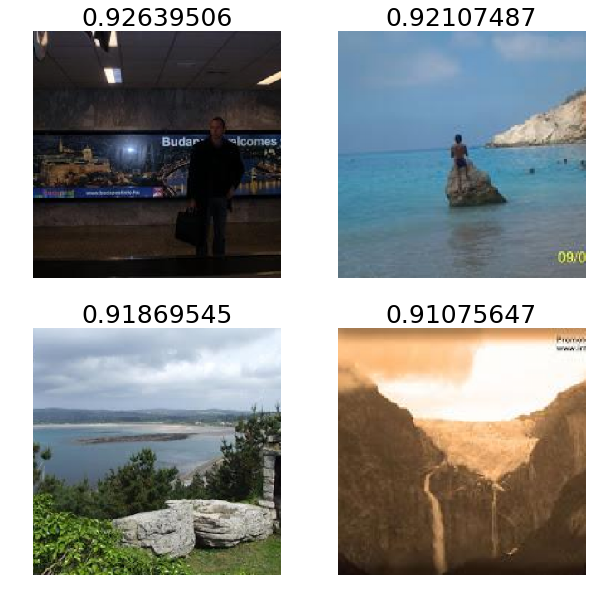

In [96]:
show_most_correct(4, correct=False)

we can see the above misclassified images are even hard to classify for humans as well.  
The 1st image is dark and looks like a subway, the second is a sea, and can overlap on many locations.  
The 3rd is again covered mostly by water and sky, and the 4th is some waterfall with bad coloring.

most Correct Photos


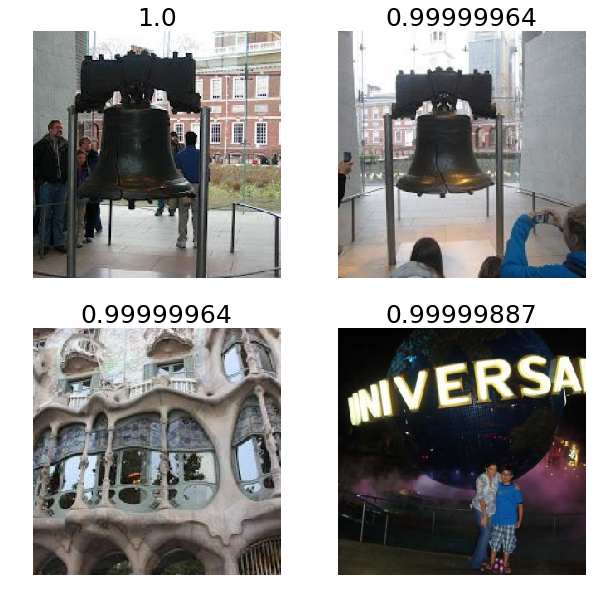

In [97]:
show_most_correct(4, correct=True)

The Above Photos are rightly classified and are very distinct in looks. It proves the classifier works for good images, but might fail with ambigious photos like shown above.